In [95]:
from pathlib import Path
from glob import glob
path = Path() / "Guitar Dataset"
data_path = glob(f"{path}/**/*.wav")

In [96]:
## 필터링
import torchaudio

waveform1, sample_rate = torchaudio.load(data_path[0], channels_first=False)

## Define effects
effect = ",".join(
    [
        "lowpass=frequency=300:poles=1", # apply single-pole lowpass filter
        "atempo=0.8", # reduce the speed
        "aecho=in_gain=0.8:out_gain=0.9:delays=200:decays=0.3|delays=400:decays=0.3"
        # Applying echo gives some dramatic feeling
    ],
)

## Apply effects
def apply_effect(waveform, sample_rate, effect):
    effector = torchaudio.io.AudioEffector(effect=effect)
    return effector.apply(waveform, sample_rate)

waveform2 = apply_effect(waveform1, sample_rate, effect)

print(waveform1.shape, sample_rate)
print(waveform2.shape, sample_rate)

torch.Size([88200, 1]) 44100
torch.Size([118712, 1]) 44100


In [97]:
import torch
import matplotlib.pyplot as plt

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, _ = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)

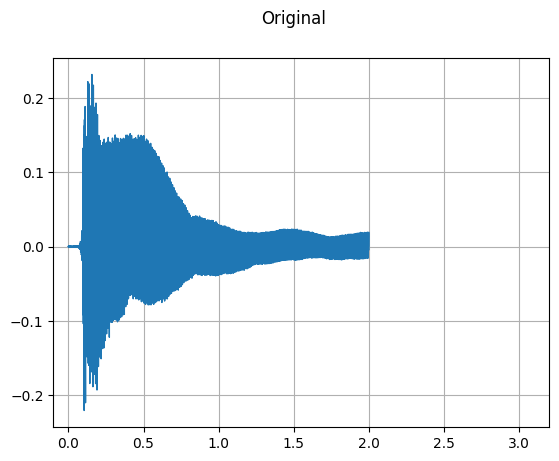

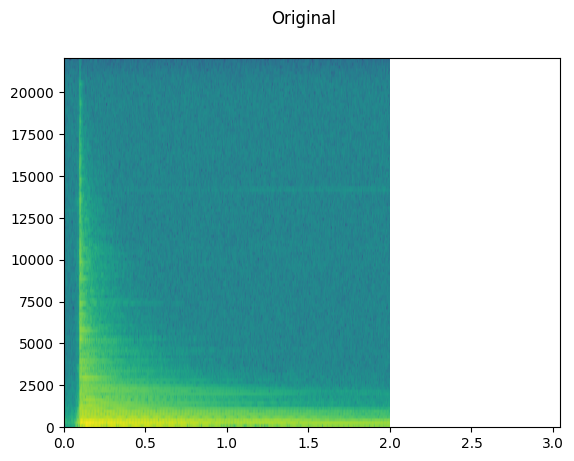

In [99]:
from IPython.display import Audio
plot_waveform(waveform1.T, sample_rate, title="Original", xlim=(-0.1, 3.2))
plot_specgram(waveform1.T, sample_rate, title="Original", xlim=(0, 3.04))
Audio(waveform1.T, rate=sample_rate)

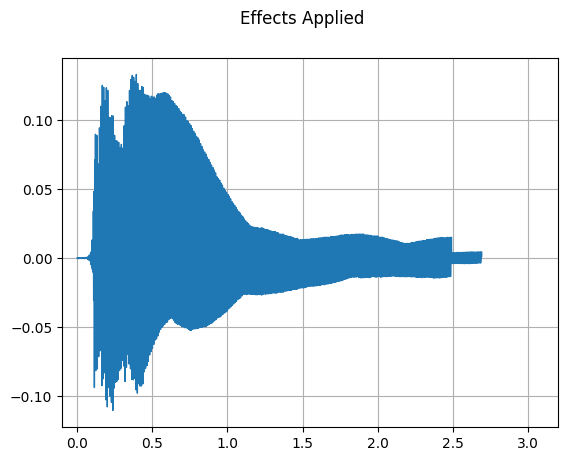

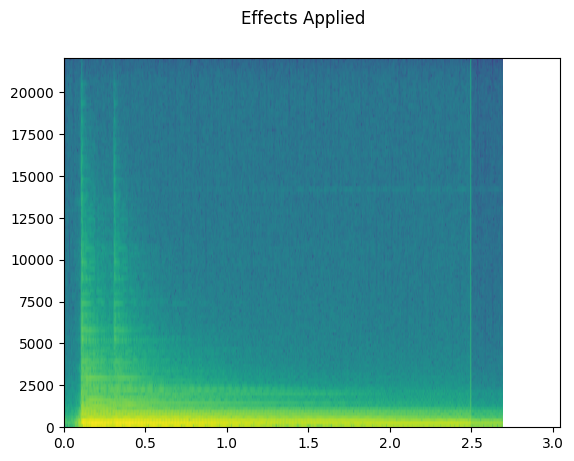

In [100]:
plot_waveform(waveform2.T, sample_rate, title="Effects Applied", xlim=(-0.1, 3.2))
plot_specgram(waveform2.T, sample_rate, title="Effects Applied", xlim=(0, 3.04))
Audio(waveform2.T, rate=sample_rate)

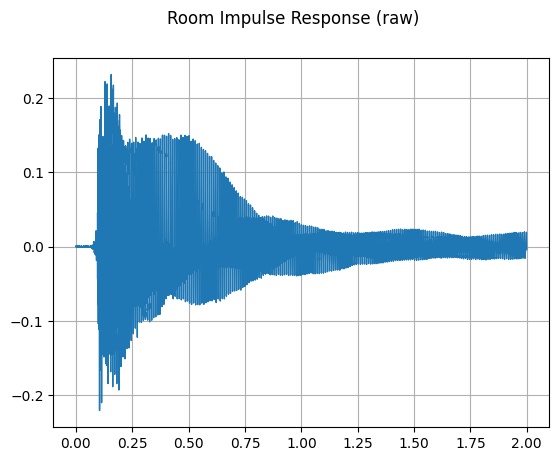

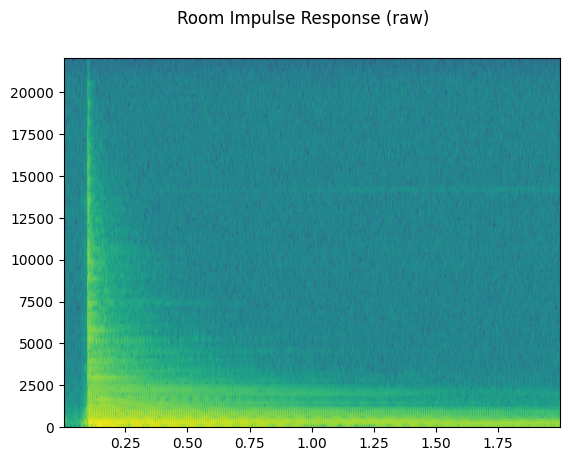

In [101]:
## Convolution
import torchaudio

rir_raw, sample_rate = torchaudio.load(data_path[0])
plot_waveform(rir_raw, sample_rate, title="Room Impulse Response (raw)")
plot_specgram(rir_raw, sample_rate, title="Room Impulse Response (raw)")
Audio(rir_raw, rate=sample_rate)

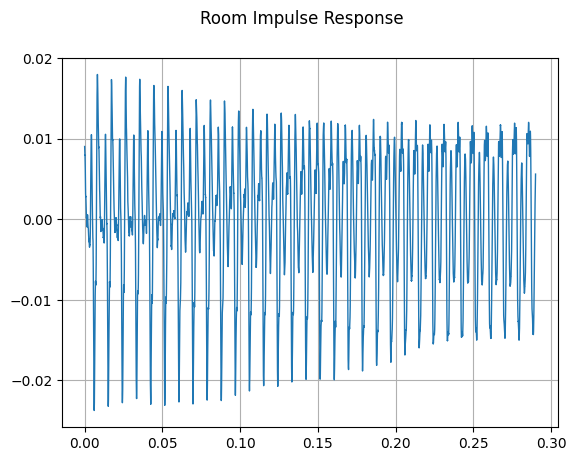

In [102]:
import torch

rir = rir_raw[:, int(sample_rate * 1.01) : int(sample_rate * 1.3)]
rir = rir / torch.linalg.vector_norm(rir, ord=2)

plot_waveform(rir, sample_rate, title="Room Impulse Response")

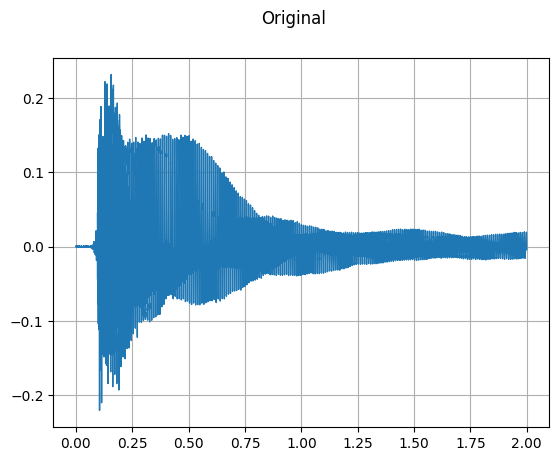

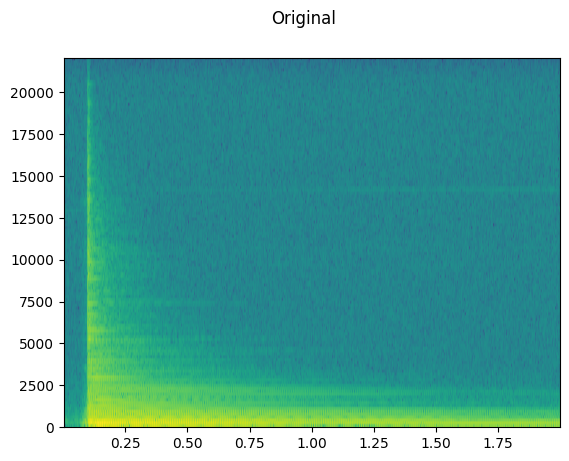

In [103]:
import torchaudio.functional as F

waveform3, _ = torchaudio.load(data_path[0])
augmented = F.fftconvolve(waveform3, rir)

plot_waveform(waveform3, sample_rate, title="Original")
plot_specgram(waveform3, sample_rate, title="Original")
Audio(waveform3, rate=sample_rate)

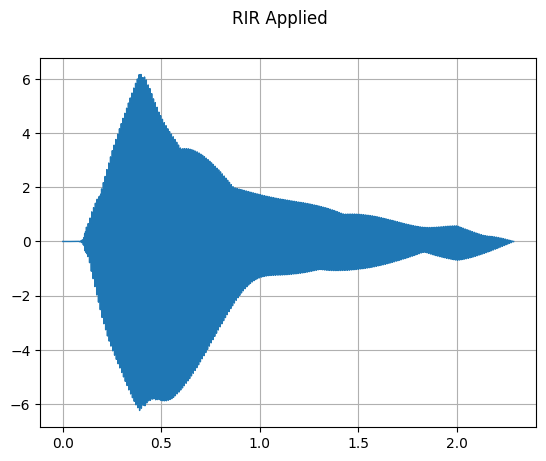

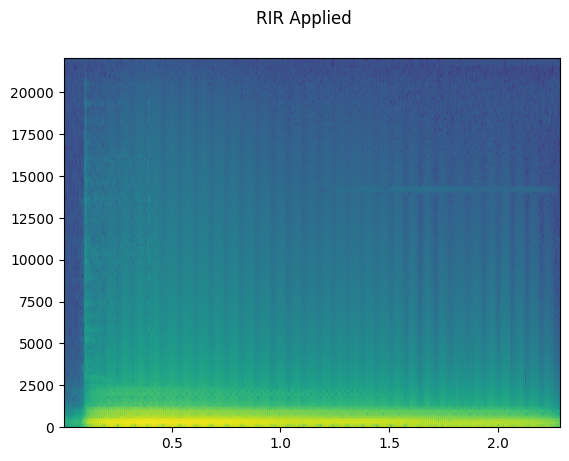

In [104]:
plot_waveform(augmented, sample_rate, title="RIR Applied")
plot_specgram(augmented, sample_rate, title="RIR Applied")
Audio(augmented, rate=sample_rate)

In [ ]:
## 배경 소음 추가

waveform4, sample_rate = torchaudio.load(data_path[0])
